In [69]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
from scipy.io import arff
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "/Users/EmperoR/ml/datasets/seismic-bumps/"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

data = arff.loadarff('/Users/EmperoR/ml/datasets/seismic-bumps/seismic-bumps.arff')
seismic_bumps_data = pd.DataFrame(data[0])
#pre-process the train_set
train_labels = seismic_bumps_data[["class"]].copy()
train_set = seismic_bumps_data.drop(["class"], axis=1)
train_labels["class"] = train_labels["class"].map(lambda x: str(x)[2])
train_set_num = seismic_bumps_data.drop(["seismic","seismoacoustic","shift", "ghazard", "class"], axis=1)
train_set_cat = seismic_bumps_data.drop(["genergy","gpuls","gdenergy", "gdpuls", "nbumps", "nbumps2", "nbumps3", "nbumps4", "nbumps5", "nbumps6", "nbumps7", "nbumps89", "energy", "maxenergy", "class"], axis=1)
#build the pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),('std_scaler', StandardScaler()),])
full_pipeline = ColumnTransformer([("num", num_pipeline, list(train_set_num)),("cat", OneHotEncoder(), list(train_set_cat)),])
#prepare the data
train_set_prepared = full_pipeline.fit_transform(train_set)
#prepare the target
encoder = LabelEncoder()
train_labels_prepared = encoder.fit_transform(train_labels)

//anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [70]:
#train the model using 10-fold cross validation and get the confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
dc_clf = DummyClassifier(strategy='stratified')
train_prediction = cross_val_predict(dc_clf.fit(train_set_prepared, train_labels_prepared), train_set_prepared, train_labels_prepared, cv=10)
confusion_matrix(train_labels_prepared, train_prediction)

array([[2249,  165],
       [ 158,   12]])

In [71]:
#compute the precision and recall
from sklearn.metrics import precision_score, recall_score
precision_score = precision_score(train_labels_prepared, train_prediction)
recall_score = recall_score(train_labels_prepared, train_prediction)
print("precision is + %f" % precision_score)
print("recall is + %f" % recall_score)

precision is + 0.067797
recall is + 0.070588


Saving figure dc_roc_curve


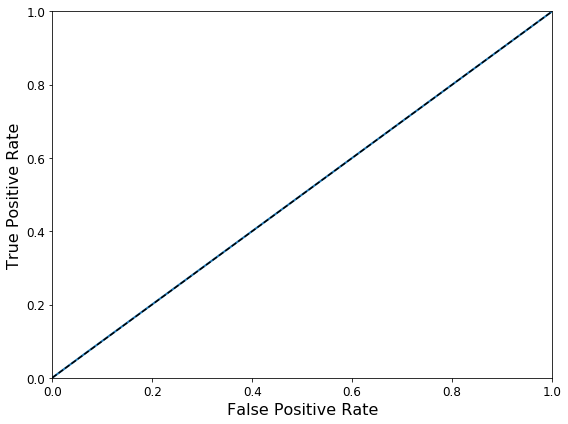

In [72]:
#plot the ROC curve
from sklearn.metrics import roc_curve
train_scores = cross_val_predict(dc_clf, train_set_prepared, train_labels_prepared, cv=10, method="predict_proba")
fpr, tpr, thresholds = roc_curve(train_labels_prepared, train_scores[:,1])
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("dc_roc_curve")
plt.show()

In [73]:
#compute the auc score
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(train_labels_prepared, train_scores[:,1])
print("Model of rule-based learning auc score is %f" % auc_score)

Model of rule-based learning auc score is 0.500249


In [74]:
#dump model in a gzip compressed file
import joblib
joblib.dump(dc_clf, PROJECT_ROOT_DIR + 'rule_based_model' + '.gz', compress=('gzip', 3))

['/Users/EmperoR/ml/datasets/seismic-bumps/rule_based_model.gz']